# Tools and functions

In [ ]:
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (4, 3)
import requests
import json
# rate limiting is important to avoid accidental service abuse of the OpenFDA API provider
from ratelimit import limits, sleep_and_retry
!pip install pyperclip
import pyperclip as clip


# cache API calls in a sqllite file to reduce the number of requests to openfda server
import requests_cache
requests_cache.install_cache('openfda_cache')

OPENFDA_API = "https://api.fda.gov/drug/event.json"

@sleep_and_retry
@limits(calls=40, period=60)
def call_api(params):
    """
    OpenFDA API call. Respects rate limit. Overrides default data limit
    Input: dictionary with API parameters {search: '...', count: '...'}
    Output: nested dictionary representation of the JSON results section
    
    OpenFDA API rate limits:
         With no API key: 40 requests per minute, per IP address. 1000 requests per day, per IP address.
         With an API key: 240 requests per minute, per key. 120000 requests per day, per key.
    """
    if not params:
        params = {}
    params['limit'] = params.get('limit', 1000)
    response = requests.get(OPENFDA_API, params=params)
    
    print(response.url)

    if response.status_code != 200:
        raise Exception('API response: {}'.format(response.status_code))
    return response.json()['results']


OPENFDA_METADATA_YAML = "https://open.fda.gov/fields/drugevent.yaml"
# munch is a yaml parser with javascript-style object access
from munch import Munch

def api_meta():
    """
    YAML file with field description and other metadata retrieved from the OpenFDA website
    Parses YAML file and provides syntactic sugar for accessing nested dictionaries
    Example: .patient.properties.patientagegroup.possible_values.value
    Note: reserved words, such as count and items still have to be accessed via ['count'], ['items']
    """
    response = requests.get(OPENFDA_METADATA_YAML)
    if response.status_code != 200:
        raise Exception('Could not retrieve YAML file with drug event API fields')
    y = Munch.fromYAML(response.text)
    return y['properties']
    

In [113]:
def enumerate_quarters(start_year, end_year):
    quarters = []
    for year in range(start_year, end_year + 1):
        for quarter in range(1, 5):  # Q1 to Q4
            quarters.append(f"{year}Q{quarter}")
    return quarters



quarters = enumerate_quarters(2017, 2024)
filelist = '\n'.join([ 'https://fis.fda.gov/content/Exports/faers_ascii_{}.zip'.format(q) for q in quarters])
print(filelist)
clip.copy(filelist)




https://fis.fda.gov/content/Exports/faers_ascii_2017Q1.zip
https://fis.fda.gov/content/Exports/faers_ascii_2017Q2.zip
https://fis.fda.gov/content/Exports/faers_ascii_2017Q3.zip
https://fis.fda.gov/content/Exports/faers_ascii_2017Q4.zip
https://fis.fda.gov/content/Exports/faers_ascii_2018Q1.zip
https://fis.fda.gov/content/Exports/faers_ascii_2018Q2.zip
https://fis.fda.gov/content/Exports/faers_ascii_2018Q3.zip
https://fis.fda.gov/content/Exports/faers_ascii_2018Q4.zip
https://fis.fda.gov/content/Exports/faers_ascii_2019Q1.zip
https://fis.fda.gov/content/Exports/faers_ascii_2019Q2.zip
https://fis.fda.gov/content/Exports/faers_ascii_2019Q3.zip
https://fis.fda.gov/content/Exports/faers_ascii_2019Q4.zip
https://fis.fda.gov/content/Exports/faers_ascii_2020Q1.zip
https://fis.fda.gov/content/Exports/faers_ascii_2020Q2.zip
https://fis.fda.gov/content/Exports/faers_ascii_2020Q3.zip
https://fis.fda.gov/content/Exports/faers_ascii_2020Q4.zip
https://fis.fda.gov/content/Exports/faers_ascii_2021Q1.z

In [ ]:
## utils 
def remove_duplicates(a):
    unique_list = []
    result = []
    for d in a:
        json_str = json.dumps(d, sort_keys=True)
        if json_str not in unique_list:
            unique_list.append(json_str)
            result.append(d)
    return unique_list,result

# Basic Statistics

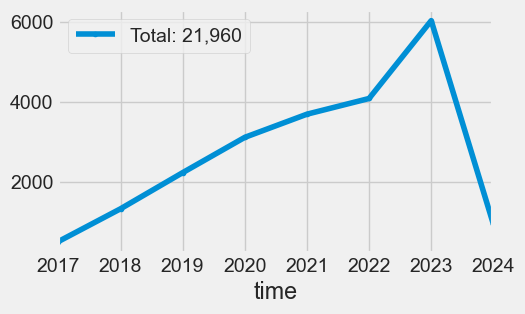

In [105]:
df = pd.DataFrame(
    call_api({
        'count':'receivedate',
        'search': 
                "receivedate:([20170301 TO 20240330]) AND "
                "patient.drug.openfda.generic_name: ribociclib "
    }));

df.index = pd.to_datetime(df.time)
# tally reports by year
df.drop('time', axis=1).resample("YE").sum().plot(style='.-', figsize=(5, 3))
total = df['count'].sum()
plt.gca().legend(["Total: {:,}".format(total)])
plt.show()


# Association of drugs with adverse drug reaction events

In [98]:
from tqdm import tqdm

adr = []
# load only the first 100 pages by 100 reports = 10,000 events
for page in tqdm(range(1000000)):
    try:
        d = call_api({
            'search':
                "receivedate:([20170301 TO 20240330]) AND "
                "patient.drug.openfda.generic_name: {} "
                "".format("ribociclib"),
            'limit': 1000,
            'skip': page
        })
    except:
        raise
        break
    print('done for page no. {} with len = {}'.format(page, len(d)))
    adr += d

"Total ADR events loaded", len(adr)

  0%|          | 1/1000000 [00:00<48:46:27,  5.70it/s]

done for page no. 0 with len = 1000


  0%|          | 3/1000000 [00:00<81:23:23,  3.41it/s] 

done for page no. 1 with len = 1000
done for page no. 2 with len = 1000


  0%|          | 4/1000000 [00:01<62:56:31,  4.41it/s]

done for page no. 3 with len = 1000
done for page no. 4 with len = 1000


  0%|          | 7/1000000 [00:01<42:13:22,  6.58it/s]

done for page no. 5 with len = 1000
done for page no. 6 with len = 1000


  0%|          | 8/1000000 [00:01<38:23:23,  7.24it/s]

done for page no. 7 with len = 1000


  0%|          | 10/1000000 [00:02<63:17:25,  4.39it/s]

done for page no. 8 with len = 1000
done for page no. 9 with len = 1000
done for page no. 10 with len = 1000


  0%|          | 13/1000000 [00:02<43:23:31,  6.40it/s]

done for page no. 11 with len = 1000
done for page no. 12 with len = 1000


  0%|          | 15/1000000 [00:03<63:37:54,  4.37it/s]

done for page no. 13 with len = 1000
done for page no. 14 with len = 1000


  0%|          | 18/1000000 [00:03<43:59:06,  6.32it/s]

done for page no. 15 with len = 1000
done for page no. 16 with len = 1000
done for page no. 17 with len = 1000


  0%|          | 19/1000000 [00:03<45:17:03,  6.13it/s]

done for page no. 18 with len = 1000


  0%|          | 21/1000000 [00:03<45:09:48,  6.15it/s]

done for page no. 19 with len = 1000
done for page no. 20 with len = 1000


  0%|          | 22/1000000 [00:04<90:06:20,  3.08it/s]

done for page no. 21 with len = 1000
done for page no. 22 with len = 1000


  0%|          | 24/1000000 [00:04<63:49:33,  4.35it/s]

done for page no. 23 with len = 1000
done for page no. 24 with len = 1000


  0%|          | 27/1000000 [00:05<48:25:34,  5.74it/s]

done for page no. 25 with len = 1000
done for page no. 26 with len = 1000


  0%|          | 29/1000000 [00:05<42:08:47,  6.59it/s]

done for page no. 27 with len = 1000
done for page no. 28 with len = 1000
done for page no. 29 with len = 1000


  0%|          | 31/1000000 [00:15<573:40:26,  2.07s/it]

done for page no. 30 with len = 1000


  0%|          | 32/1000000 [01:50<6518:20:04, 23.47s/it]

done for page no. 31 with len = 1000


  0%|          | 33/1000000 [02:02<5749:50:22, 20.70s/it]

done for page no. 32 with len = 1000


  0%|          | 34/1000000 [03:53<12313:31:16, 44.33s/it]

done for page no. 33 with len = 1000


  0%|          | 35/1000000 [04:01<9554:42:28, 34.40s/it] 

done for page no. 34 with len = 1000


  0%|          | 36/1000000 [05:59<16012:03:27, 57.65s/it]

done for page no. 35 with len = 1000


  0%|          | 37/1000000 [06:09<12261:58:59, 44.14s/it]

done for page no. 36 with len = 1000


  0%|          | 38/1000000 [08:03<17873:40:21, 64.35s/it]

done for page no. 37 with len = 1000


  0%|          | 39/1000000 [08:10<13204:16:12, 47.54s/it]

done for page no. 38 with len = 1000


  0%|          | 40/1000000 [09:37<16456:11:35, 59.24s/it]

done for page no. 39 with len = 1000


  0%|          | 41/1000000 [09:49<12592:53:48, 45.34s/it]

done for page no. 40 with len = 1000


  0%|          | 42/1000000 [11:27<16933:31:11, 60.96s/it]

done for page no. 41 with len = 1000


  0%|          | 43/1000000 [11:37<12671:35:42, 45.62s/it]

done for page no. 42 with len = 1000


  0%|          | 44/1000000 [11:46<9676:10:15, 34.84s/it] 

done for page no. 43 with len = 1000


  0%|          | 45/1000000 [13:09<13683:04:39, 49.26s/it]

done for page no. 44 with len = 1000


  0%|          | 46/1000000 [13:18<10275:49:28, 36.99s/it]

done for page no. 45 with len = 1000


  0%|          | 47/1000000 [13:27<7983:02:04, 28.74s/it] 

done for page no. 46 with len = 1000


  0%|          | 48/1000000 [15:04<13681:40:47, 49.26s/it]

done for page no. 47 with len = 1000


  0%|          | 49/1000000 [15:09<10013:21:53, 36.05s/it]

done for page no. 48 with len = 1000


  0%|          | 50/1000000 [15:18<7747:00:33, 27.89s/it] 

done for page no. 49 with len = 1000


  0%|          | 51/1000000 [17:29<16345:55:48, 58.85s/it]

done for page no. 50 with len = 1000


  0%|          | 52/1000000 [17:36<11996:56:28, 43.19s/it]

done for page no. 51 with len = 1000


  0%|          | 53/1000000 [17:43<9005:18:27, 32.42s/it] 

done for page no. 52 with len = 1000


  0%|          | 54/1000000 [19:33<15417:12:13, 55.50s/it]

done for page no. 53 with len = 1000


  0%|          | 55/1000000 [19:42<11538:17:26, 41.54s/it]

done for page no. 54 with len = 1000


  0%|          | 56/1000000 [19:49<8686:59:22, 31.27s/it] 

done for page no. 55 with len = 1000


  0%|          | 57/1000000 [22:13<18066:59:46, 65.04s/it]

done for page no. 56 with len = 1000


  0%|          | 58/1000000 [22:23<13524:12:19, 48.69s/it]

done for page no. 57 with len = 1000


  0%|          | 59/1000000 [22:33<10242:54:58, 36.88s/it]

done for page no. 58 with len = 1000


  0%|          | 60/1000000 [24:40<17785:20:11, 64.03s/it]

done for page no. 59 with len = 1000


  0%|          | 61/1000000 [24:50<13276:37:09, 47.80s/it]

done for page no. 60 with len = 1000


  0%|          | 62/1000000 [24:58<9920:42:10, 35.72s/it] 

done for page no. 61 with len = 1000


  0%|          | 63/1000000 [26:54<16673:49:42, 60.03s/it]

done for page no. 62 with len = 1000


  0%|          | 64/1000000 [27:01<12223:02:34, 44.01s/it]

done for page no. 63 with len = 1000


  0%|          | 65/1000000 [27:08<9127:34:13, 32.86s/it] 

done for page no. 64 with len = 1000


  0%|          | 66/1000000 [29:07<16302:28:47, 58.69s/it]

done for page no. 65 with len = 1000


  0%|          | 67/1000000 [29:15<12088:08:08, 43.52s/it]

done for page no. 66 with len = 1000


  0%|          | 68/1000000 [29:21<8999:52:29, 32.40s/it] 

done for page no. 67 with len = 1000


  0%|          | 69/1000000 [31:30<16994:22:08, 61.18s/it]

done for page no. 68 with len = 1000


  0%|          | 70/1000000 [31:36<12437:09:48, 44.78s/it]

done for page no. 69 with len = 1000


  0%|          | 71/1000000 [31:43<9293:53:37, 33.46s/it] 

done for page no. 70 with len = 1000


  0%|          | 72/1000000 [32:25<9981:47:59, 35.94s/it]

done for page no. 71 with len = 1000


  0%|          | 73/1000000 [32:33<7656:22:13, 27.56s/it]

done for page no. 72 with len = 1000


  0%|          | 74/1000000 [32:44<6268:30:34, 22.57s/it]

done for page no. 73 with len = 1000


  0%|          | 75/1000000 [32:52<5101:24:15, 18.37s/it]

done for page no. 74 with len = 1000


  0%|          | 76/1000000 [33:10<5010:32:43, 18.04s/it]

done for page no. 75 with len = 1000


  0%|          | 77/1000000 [33:17<4109:51:20, 14.80s/it]

done for page no. 76 with len = 1000


  0%|          | 78/1000000 [33:26<3623:21:52, 13.05s/it]

done for page no. 77 with len = 1000


  0%|          | 79/1000000 [33:34<3197:13:20, 11.51s/it]

done for page no. 78 with len = 1000


  0%|          | 80/1000000 [33:43<3016:06:21, 10.86s/it]

done for page no. 79 with len = 1000


  0%|          | 81/1000000 [33:53<2901:16:08, 10.45s/it]

done for page no. 80 with len = 1000


  0%|          | 82/1000000 [34:01<2733:51:23,  9.84s/it]

done for page no. 81 with len = 1000


  0%|          | 83/1000000 [34:09<2590:00:11,  9.32s/it]

done for page no. 82 with len = 1000


  0%|          | 84/1000000 [34:16<2371:05:53,  8.54s/it]

done for page no. 83 with len = 1000


  0%|          | 85/1000000 [34:22<2164:35:57,  7.79s/it]

done for page no. 84 with len = 1000


  0%|          | 86/1000000 [35:57<9462:46:00, 34.07s/it]

done for page no. 85 with len = 1000


  0%|          | 87/1000000 [36:07<7439:18:06, 26.78s/it]

done for page no. 86 with len = 1000


  0%|          | 88/1000000 [36:14<5823:04:40, 20.96s/it]

done for page no. 87 with len = 1000


  0%|          | 89/1000000 [39:06<18341:58:26, 66.04s/it]

done for page no. 88 with len = 1000


  0%|          | 90/1000000 [39:17<13776:50:33, 49.60s/it]

done for page no. 89 with len = 1000


  0%|          | 91/1000000 [39:25<10281:25:48, 37.02s/it]

done for page no. 90 with len = 1000


  0%|          | 92/1000000 [41:15<16380:54:35, 58.98s/it]

done for page no. 91 with len = 1000


  0%|          | 93/1000000 [41:23<12128:06:31, 43.67s/it]

done for page no. 92 with len = 1000


  0%|          | 94/1000000 [41:33<9366:48:48, 33.72s/it] 

done for page no. 93 with len = 1000


  0%|          | 95/1000000 [44:02<18912:31:49, 68.09s/it]

done for page no. 94 with len = 1000


  0%|          | 96/1000000 [44:10<13975:37:57, 50.32s/it]

done for page no. 95 with len = 1000


  0%|          | 97/1000000 [44:19<10502:38:09, 37.81s/it]

done for page no. 96 with len = 1000


  0%|          | 98/1000000 [47:25<22821:13:20, 82.16s/it]

done for page no. 97 with len = 1000


  0%|          | 99/1000000 [47:34<16746:47:05, 60.29s/it]

done for page no. 98 with len = 1000


  0%|          | 100/1000000 [47:44<12522:00:28, 45.08s/it]

done for page no. 99 with len = 1000


  0%|          | 101/1000000 [49:24<17104:46:28, 61.58s/it]

done for page no. 100 with len = 1000


  0%|          | 102/1000000 [49:32<12641:18:40, 45.51s/it]

done for page no. 101 with len = 1000


  0%|          | 103/1000000 [49:39<9485:48:52, 34.15s/it] 

done for page no. 102 with len = 1000


  0%|          | 104/1000000 [51:53<17746:53:22, 63.90s/it]

done for page no. 103 with len = 1000


  0%|          | 105/1000000 [52:01<13107:09:24, 47.19s/it]

done for page no. 104 with len = 1000


  0%|          | 106/1000000 [52:10<9950:47:34, 35.83s/it] 

done for page no. 105 with len = 1000


  0%|          | 107/1000000 [54:35<19021:12:05, 68.48s/it]

done for page no. 106 with len = 1000


  0%|          | 108/1000000 [54:41<13860:21:22, 49.90s/it]

done for page no. 107 with len = 1000


  0%|          | 109/1000000 [54:50<10408:54:40, 37.48s/it]

done for page no. 108 with len = 1000


  0%|          | 110/1000000 [57:23<20029:25:48, 72.11s/it]

done for page no. 109 with len = 1000


  0%|          | 111/1000000 [57:32<14821:54:36, 53.36s/it]

done for page no. 110 with len = 1000


  0%|          | 112/1000000 [57:42<11158:58:11, 40.18s/it]

done for page no. 111 with len = 1000


  0%|          | 113/1000000 [59:24<16291:38:54, 58.66s/it]

done for page no. 112 with len = 1000


  0%|          | 114/1000000 [59:33<12174:49:58, 43.83s/it]

done for page no. 113 with len = 1000


  0%|          | 115/1000000 [59:47<9663:49:10, 34.79s/it] 

done for page no. 114 with len = 1000


  0%|          | 116/1000000 [1:02:25<19947:28:46, 71.82s/it]

done for page no. 115 with len = 1000


  0%|          | 117/1000000 [1:02:32<14569:25:40, 52.46s/it]

done for page no. 116 with len = 1000


  0%|          | 118/1000000 [1:02:39<10753:32:07, 38.72s/it]

done for page no. 117 with len = 1000


  0%|          | 119/1000000 [1:04:45<18063:07:23, 65.03s/it]

done for page no. 118 with len = 1000


  0%|          | 120/1000000 [1:04:54<13425:19:29, 48.34s/it]

done for page no. 119 with len = 1000


  0%|          | 121/1000000 [1:05:04<10201:41:54, 36.73s/it]

done for page no. 120 with len = 1000


  0%|          | 122/1000000 [1:07:43<20412:49:59, 73.50s/it]

done for page no. 121 with len = 1000


  0%|          | 123/1000000 [1:07:53<15063:28:05, 54.24s/it]

done for page no. 122 with len = 1000


  0%|          | 124/1000000 [1:07:59<11094:36:58, 39.95s/it]

done for page no. 123 with len = 1000


  0%|          | 125/1000000 [1:10:15<19095:14:24, 68.75s/it]

done for page no. 124 with len = 1000


  0%|          | 126/1000000 [1:10:36<15121:48:28, 54.45s/it]

done for page no. 125 with len = 1000


  0%|          | 127/1000000 [1:10:43<11140:24:28, 40.11s/it]

done for page no. 126 with len = 1000


  0%|          | 128/1000000 [1:13:00<19214:07:47, 69.18s/it]

done for page no. 127 with len = 1000


  0%|          | 129/1000000 [1:13:09<14185:32:20, 51.07s/it]

done for page no. 128 with len = 1000


  0%|          | 130/1000000 [1:13:19<10770:29:42, 38.78s/it]

done for page no. 129 with len = 1000


  0%|          | 131/1000000 [1:16:56<25651:10:30, 92.36s/it]

done for page no. 130 with len = 1000


  0%|          | 132/1000000 [1:17:03<18491:03:24, 66.58s/it]

done for page no. 131 with len = 1000


  0%|          | 133/1000000 [1:17:11<13666:42:00, 49.21s/it]

done for page no. 132 with len = 1000


  0%|          | 134/1000000 [1:20:45<27343:15:16, 98.45s/it]

done for page no. 133 with len = 1000


  0%|          | 135/1000000 [1:20:51<19672:00:27, 70.83s/it]

done for page no. 134 with len = 1000


  0%|          | 136/1000000 [1:21:00<14532:33:59, 52.32s/it]

done for page no. 135 with len = 1000


  0%|          | 137/1000000 [1:23:53<24567:21:25, 88.45s/it]

done for page no. 136 with len = 1000


  0%|          | 137/1000000 [1:46:43<12982:09:45, 46.74s/it]


ChunkedEncodingError: ("Connection broken: InvalidChunkLength(got length b'', 0 bytes read)", InvalidChunkLength(got length b'', 0 bytes read))

In [ ]:
!pip install jsondiff
import jsondiff
jsondiff.diff(sr_list[8],sr_list[4],syntax='symmetric')

In [99]:
sr_list = [ x for x in adr if x['safetyreportid'] == '13476514' ]

In [100]:
len(sr_list)

12

In [49]:
import json




In [101]:
sr_list[0] == sr_list[1] 

True

In [ ]:
sr_list = [ x for x in uniq_list if x['safetyreportid'] == '13324685' ]

In [ ]:
jsondiff.diff(sr_list[0],sr_list[1],syntax='symmetric')

## openFDA 数据请求结果保存

In [ ]:
import pickle
#with open('rib.pickle','wb') as outfile:
#    pickle.dump(adr, outfile)

with open('rib.pickle','rb') as infile:
    adr = pickle.load(infile)



In [102]:
unique_list_str, unique_list_json = remove_duplicates(adr)

1136, type <class 'list'>


In [104]:
print("got result len {}, after unique {}, type {}".format(len(adr), len(unique_list_str), type(unique_list_json)))


got result len 137000, after unique 1136, type <class 'list'>


In [52]:
unique_list_json[1]

{'safetyreportversion': '2',
 'safetyreportid': '13324685',
 'primarysourcecountry': 'US',
 'occurcountry': 'US',
 'transmissiondateformat': '102',
 'transmissiondate': '20170830',
 'reporttype': '2',
 'serious': '1',
 'seriousnesshospitalization': '1',
 'receivedateformat': '102',
 'receivedate': '20170310',
 'receiptdateformat': '102',
 'receiptdate': '20170613',
 'fulfillexpeditecriteria': '1',
 'companynumb': 'PHHO2017US004561',
 'duplicate': '1',
 'reportduplicate': {'duplicatesource': 'SANDOZ',
  'duplicatenumb': 'PHHO2017US004561'},
 'primarysource': {'reportercountry': 'US', 'qualification': '3'},
 'sender': {'sendertype': '2', 'senderorganization': 'FDA-Public Use'},
 'receiver': {'receivertype': '6', 'receiverorganization': 'FDA'},
 'patient': {'patientonsetage': '65',
  'patientonsetageunit': '801',
  'patientweight': '100',
  'patientsex': '2',
  'reaction': [{'reactionmeddraversionpt': '20.0',
    'reactionmeddrapt': 'Diverticulitis',
    'reactionoutcome': '3'},
   {'reac

In [77]:
sr_list = [ x['safetyreportid'] + x['safetyreportversion']  for x in adr ]
df = pd.DataFrame(sr_list)



In [78]:
df.columns = ['id']
df.groupby(['id']).sum().reset_index()

,id
0,133240142
1,133246852
2,133624611
3,134177085
4,134232612
...,...
1024,149972001
1025,149974071
1026,149975811
1027,149992981


In [79]:
sr_list = [ x['safetyreportid']  for x in adr ]
df = pd.DataFrame(sr_list)
df.describe()

,0
count,30000
unique,1029
top,14338555
freq,30


In [107]:
sr_list = [ x for x in adr if x['safetyreportid'] == '21925314' ]
len(sr_list)


0

In [81]:
len(adr)

30000

In [86]:
a=[ x for x in adr if x['safetyreportid'] == '13674367' ]
len(a)


30

In [90]:
b =[ x['safetyreportversion'] for x in a]
unique_list_str, unique_list_json = remove_duplicates(a)

In [92]:
len(unique_list_json)

1